In [70]:
import os
import os.path as osp
import sys
sys.path.append(osp.abspath('..'))
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from model import DenseInception
from datasets.gtzan import GTZAN_MELSPEC as GTZAN


DEVICE = torch.device('cuda:0')
%matplotlib notebook
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [30]:
dataset = GTZAN(phase='all', min_segments=50, overlap=0.9)
x, y = dataset[0]
x.shape

(50, 128, 65)

In [31]:
inputs = torch.from_numpy(x).type(torch.FloatTensor).unsqueeze(0).to(DEVICE)
labels = torch.LongTensor([y]).to(DEVICE)
inputs.shape
labels.shape

torch.Size([1])

In [5]:
net = DenseInception(1, 32, 3).to(DEVICE)
net.load_state_dict(torch.load('checkpoints/densenet_recurrent_batch_4_randomized_segment_fold_3.pth'), strict=False)

In [32]:
preds = F.softmax(net(inputs), dim=2).cpu().detach().numpy().squeeze()

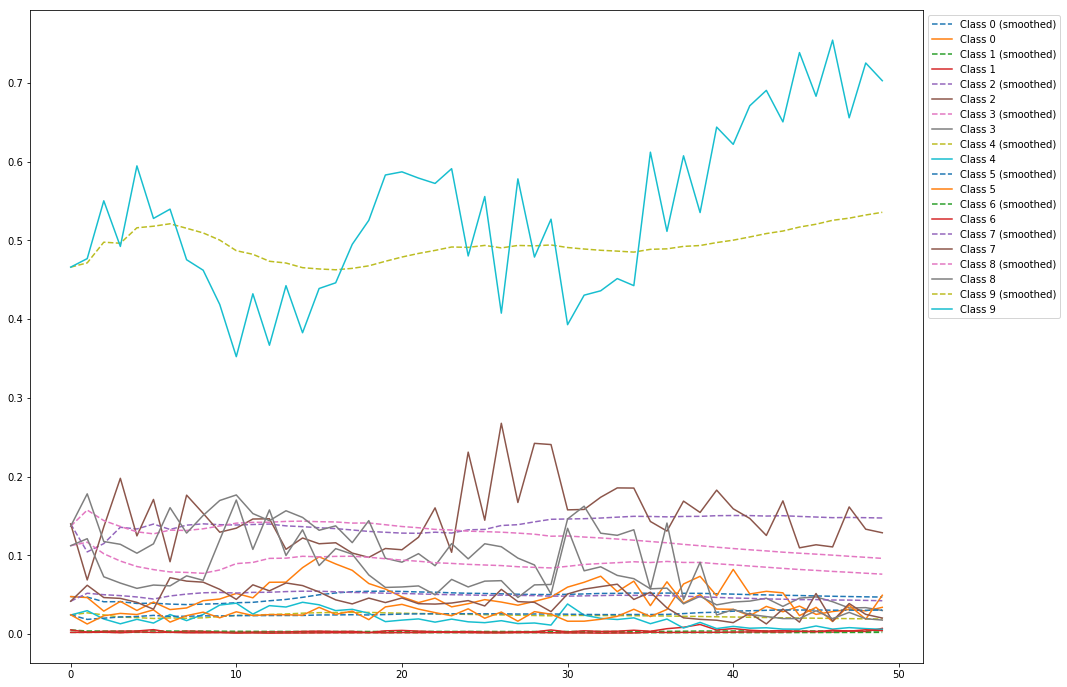

In [50]:
preds_t = preds.T
plt.figure(figsize=(16, 12))
for n, class_x in enumerate(preds_t):
    smoothed_class_x = np.cumsum(class_x) /  np.arange(1, 1 + len(class_x))
    plt.plot(smoothed_class_x, '--', label='Class {} (smoothed)'.format(n))
    plt.plot(class_x, label='Class {}'.format(n))
plt.legend(bbox_to_anchor=(1, 1))
plt.show()

<IPython.core.display.Javascript object>


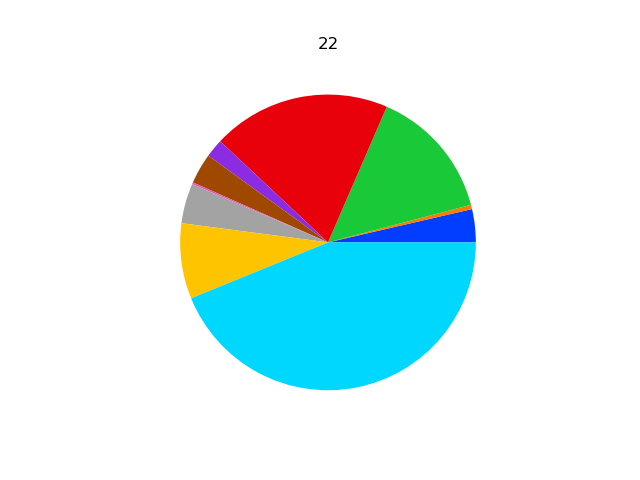

In [77]:
from matplotlib.animation import FuncAnimation

fig, ax = plt.subplots()
colors = sns.color_palette("bright", 10)

def update(num):
    ax.clear()
    ax.axis('equal')
    ax.set_title(str(num))
    ax.pie(preds[num], colors=colors)

ani = FuncAnimation(fig, update, frames=range(len(preds)),
                    interval=200, repeat=True, blit=True)
plt.show()